# NET319 - Using SageMaker Random Cut Forests to detect anomalies in VPC Flow Logs

***Unsupervised anomaly detection on timeseries data using the Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)


# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the VPC FLow Logs that are being delivered to Amazon S3 from Kinesis Firehose. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

In [199]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'vpc-flowlogs-analytics-666379320848-eu-west-1'# <--specify the bucket created in CloudFormation (VPCFLBucketName)
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()



# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://vpc-flowlogs-analytics-666379320848-eu-west-1/sagemaker/rcf-benchmarks


## Obtain and Inspect Example Data


Our data comes from the VPC Flow Logs in your environment. The raw file is a JSON file, which will need to be read into a Pandas DataFrame. The data consists of the network traffic to and from the web servers that were launced as part of the CloudFormation template. It includes the source and destination ip addresses and ports, protocols, packets, number of bytes and status of the connection. 

In [200]:
%%time
import datetime
import pandas as pd

s3 = boto3.resource('s3')
client = boto3.client('s3')
orig_bucket = s3.Bucket(bucket)
s3prefix = "firehose/2018/"   # Enter the prefix for the FlowLog files
i = 0
combined_data = pd.DataFrame()

# fetch each file in the folder listed above
for key in orig_bucket.objects.filter(Prefix=s3prefix): 
    response = client.get_object(Bucket=bucket,Key=key.key)

    filecontent = response['Body'].read().decode('utf-8')
    # The VPC Flow Log is one continuous string. We need to separate each record into its own line
    filecontent = filecontent.replace('}{', '}\n{')
    # We create an array where each line is becomes a row that we can work with
    vpcflarray = filecontent.split("\n")
    for row in vpcflarray:  
        #print(row)
        #Convert each row into a DataFrame, and append it to a DataFrame that will contain all rows in all files
        data = pd.read_json(row, lines=True)
        combined_data = combined_data.append(data)
    

CPU times: user 1min 13s, sys: 0 ns, total: 1min 13s
Wall time: 1min 23s


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [201]:
print(combined_data.head(10))
combined_data.info()

                 @timestamp    account-id  action  bytes    destaddr  \
0  2018-11-14T00:06:47.562Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:06:47.562Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     44  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     44  10.0.1.195   
0  2018-11-14T00:26:35.654Z  666379320848  ACCEPT     40  10.0.1.195   

  direction  dstport         end           interface-id log-status  packets  \
0   inbound    49883  1542153681  eni-0f4a9d00762510513         OK        1   
0   inbound     8088  1542153501  eni-0f4a9d00762

You will notice that there is a number of columns where the data doesn't change, such as account-id, action, version etc. We can drop these columns as they will have no impact on our model. We can also derive some useful data, such as the length of the connection, or duration. We calculate this by subracting the value for start from the value for end. We will also need to break out the ip addresses into separate columns, as RCF algorithm cannot process string values. You'll notice that we are only keep the last section of the destination address (destaddr) as we will know the first 3 sections of the address.

In [202]:
#drop rows which do not contain data
combined_data = combined_data[~combined_data['log-status'].isin(["NODATA"])]

#drop rows where the src address is our own internal webservers
combined_data = combined_data[~combined_data['srcaddr'].str.startswith('10.0')]

#add a new column to the the dataframe     
combined_data['duration'] = combined_data.end - combined_data.start
    
#break out each section of srcaddr into separate columns    
combined_data['src-q1'] = combined_data['srcaddr'].str.split('.').str[0]
combined_data['src-q2'] = combined_data['srcaddr'].str.split('.').str[1]
combined_data['src-q3'] = combined_data['srcaddr'].str.split('.').str[2]
combined_data['src-q4'] = combined_data['srcaddr'].str.split('.').str[3]
#we only need the last section of destaddr to identify the destation server, we can drop the first 3 sections [10.0..]
combined_data['destaddr'] = combined_data['destaddr'].str.split('.').str[3]

#drop all columns that do not have useful data                   
combined_data.drop(['version','account-id','interface-id','start','end','log-status','action','srcaddr','security-group-ids','@timestamp'],axis=1, inplace=True)

#Rearrange the remaining columns in the following format for our CSV
combined_data = combined_data[['src-q1','src-q2','src-q3','src-q4','srcport','destaddr','dstport','protocol','packets','bytes','duration']]
combined_data.reset_index(drop=True, inplace=True)

print(combined_data.head())

  src-q1 src-q2 src-q3 src-q4  srcport destaddr  dstport  protocol  packets  \
0    134    119    193     57    59209      195    49883         6        1   
1    188    166      3     86    46366      195     8088         6        1   
2     46    101    199    124    39947      195     8088         6        1   
3    134    119    193     57    59209      195    13167         6        1   
4    167     99     82    199    53788      195     3986         6        1   

   bytes  duration  
0     40        45  
1     40        39  
2     40        38  
3     40        54  
4     40        30  


Human beings are visual creatures so let's take a look at a plot of the data. Here is a simple plot of the duration per connection. As you can see, most connections have a really low number(<70 ms). However we can also easily spot some outliers.

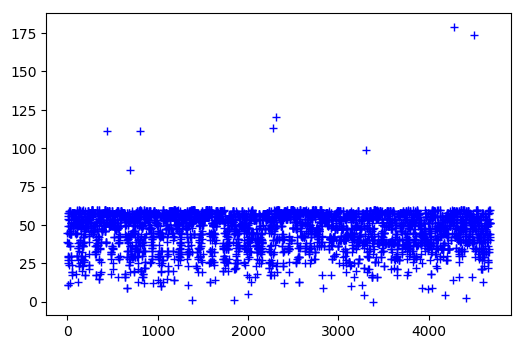

In [234]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.dpi'] = 100
x = np.linspace(0, 10, len(combined_data))

plt.plot(combined_data['duration'],'+', color='blue')

Now that our DataFrame has been cleaned, we need to generate a CSV file to train our model.


In [205]:
#Write the dataframe to csv stored locally (on Notebook instance)
combined_data.to_csv("flowlogs.csv", index=False, header=False)
#upload csv to S3
s3 = boto3.client('s3')
key =  'csv/flowlogs.csv'
s3.upload_file("flowlogs.csv", bucket, key )

# Training

***

Next, we're going to set up a training job to run, using SageMaker's RCF algorithm, and point it to the CSV file we just uploaded into S3.

In [206]:
from sagemaker import RandomCutForest
session = sagemaker.Session()

containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = boto3.Session().region_name
container = containers[region_name]

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    output_path = 's3://{}/output'.format(bucket),
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    sagemaker_session = session)

rcf.set_hyperparameters(
    num_samples_per_tree=200,
    num_trees=50,
    feature_dim=11)


train_data = sagemaker.s3_input(
     s3_data = 's3://{}/{}'.format(bucket,key),
     content_type='text/csv;label_size=0',
     distribution='ShardedByS3Key')

rcf.fit({'train': train_data})




INFO:sagemaker:Creating training-job with name: randomcutforest-2018-11-16-15-49-00-842


2018-11-16 15:49:01 Starting - Starting the training job...
Launching requested ML instances......
2018-11-16 15:50:31 Downloading - Downloading input data...
2018-11-16 15:50:37 Training - Downloading the training image...
2018-11-16 15:51:23 Uploading - Uploading generated training model
2018-11-16 15:51:29 Completed - Training job completed

Docker entrypoint called with argument(s): train
[11/16/2018 15:51:19 INFO 139810850031424] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[11/16/2018 15:51:19 INFO 139810850031424] Reading provided configuration from /opt/ml/input/config/hyperparameter

Billable seconds: 59


## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

If you see the message

> `Billable seconds: `

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [207]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2018-11-16-15-49-00-842


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [208]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-11-16-16-08-52-013
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-11-16-15-49-00-842


--------------------------------------------------------------------------!

This can take a while. The Endpoint will be available when you see a ! at the end of the line of ---- above. You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [209]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2018-11-16-15-49-00-842


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [210]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [211]:
combined_data_numpy = combined_data.values.reshape(-1,11)

print(combined_data_numpy[:6])
results = rcf_inference.predict(combined_data_numpy[:6])
print(results)

[['134' '119' '193' '57' 59209 '195' 49883 6 1 40 45]
 ['188' '166' '3' '86' 46366 '195' 8088 6 1 40 39]
 ['46' '101' '199' '124' 39947 '195' 8088 6 1 40 38]
 ['134' '119' '193' '57' 59209 '195' 13167 6 1 40 54]
 ['167' '99' '82' '199' 53788 '195' 3986 6 1 40 30]
 ['138' '68' '65' '19' 60016 '195' 8088 6 1 40 25]]
{'scores': [{'score': 0.8525232474}, {'score': 0.62898357}, {'score': 0.6513974456}, {'score': 0.7335798129}, {'score': 0.7228800533}, {'score': 0.7445288624}]}


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire dataset.

In [212]:
results = rcf_inference.predict(combined_data_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to dataframe and print first few values
combined_data['score'] = pd.Series(scores, index=combined_data.index)


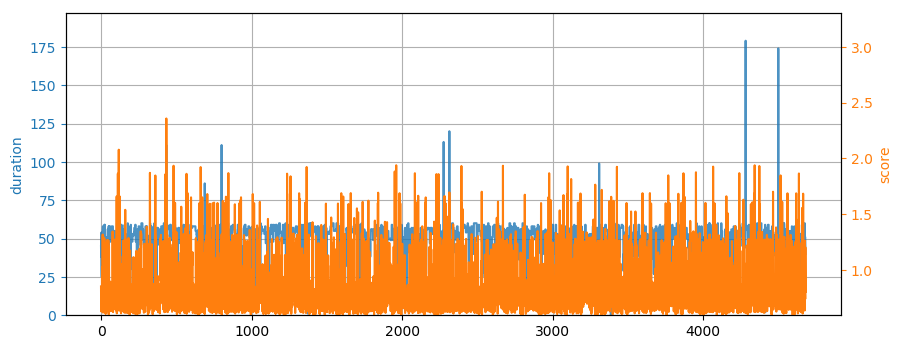

In [230]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#

start, end =  0, len(combined_data)

combined_data_subset = combined_data[start:end]


ax1.plot(combined_data_subset['duration'],color='C0', alpha=0.8)
ax2.plot(combined_data_subset['score'], color='C1')

#ax3.plot(combined_data_subset['duration'], color='C2')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('duration', color='C0')
ax2.set_ylabel('score', color='C1')


ax1.tick_params('y', colors='C0')
ax2.tick_params('y',colors='C1')
#ax3.tick_params('y', colors='C2')

ax2.set_ylim(min(scores), 1.4*max(scores))
ax1.set_ylim(0, combined_data['duration'].max()*1.1)

fig.set_figwidth(10)

##### Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 5 standard deviations from the mean score.

In [235]:
score_mean = combined_data['score'].mean()
score_std = combined_data['score'].std()
score_cutoff = score_mean + 5*score_std
print("Mean: {}".format(score_mean))
print("Standard Deviation: {}".format(score_std))
print("Score Cutoff: {}".format(score_cutoff))

anomalies = combined_data_subset[combined_data_subset['score'] > score_cutoff]
anomalies

Mean: 0.844139698836148
Standard Deviation: 0.23933285104030366
Score Cutoff: 2.040803954037666


,src-q1,src-q2,src-q3,src-q4,srcport,destaddr,dstport,protocol,packets,bytes,duration,score
118,52,219,72,53,80,195,30303,6,9,6988,49,2.078230
434,113,137,59,20,91,195,47187,6,208,9984,111,2.358082




Note that our algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot.

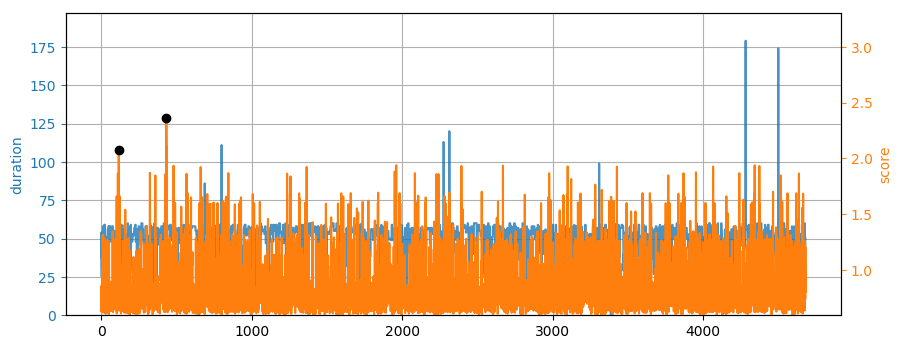

In [232]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [ ]:
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)